## Bayesian Network Concepts
In this notebook, we will review some concepts about conditional probability tables, how to estimate them and how to use them. We will do this using the [pgmpy python suite](https://pgmpy.org/index.html). We will first import the set the paths and import pgmpy into the Jupyter environment. 

In [1]:
import sys
sys.path.append('/mnt/ws/home/sroy/old-local-home/.conda/envs/pgmpy/lib/python3.10/site-packages')
sys.path

import pgmpy

/mnt/ws/home/sroy/old-local-home/.local/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Create a small dataset 
This example is a toy example with just four variables. The are `fruit`, `tasty`, `size`, `color`. We will use the python `pandas` to create this dataset. This dataset has 14 samples.  

In [15]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"],
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"],
                         'color': ["yellow","green","yellow","red","green","red","yellow",
                                  "red","yellow","green","green","yellow","red","green"]})



Let's look at our data by printing it out. Using this dataset, we will try to answer simple questions like the probability of a banana being tasty given its size.  

In [35]:
print(data)

     fruit tasty   size   color
0   banana   yes  large  yellow
1    apple    no  large   green
2   banana   yes  large  yellow
3    apple   yes  small     red
4   banana   yes  large   green
5    apple   yes  large     red
6   banana   yes  large  yellow
7    apple   yes  small     red
8    apple   yes  large  yellow
9    apple   yes  large   green
10  banana   yes  large   green
11  banana    no  large  yellow
12   apple    no  small     red
13  banana    no  small   green


## Create a Bayesian network
We will now create a Bayesian Network for our dataset. We will assume that the network will have `fruit` as the parent of `size` and `color` and, these two will determine if the fruit is tasty! We will use the `BayesianNetwork` class from pgmpy.

In [2]:
from pgmpy.models import BayesianNetwork

Specify the structure of the Bayesian network by adding edges from parent to child.

In [3]:
model=BayesianNetwork([('fruit','size'),('fruit','color'),('size', 'tasty'), ('color', 'tasty')])

Let's draw out the structure of the Bayesian network. We will use the `networkx` package for this.

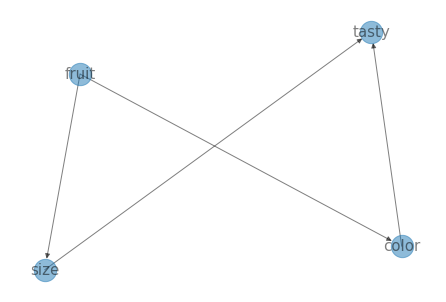

In [12]:
import importlib
import networkx as nx
import matplotlib.pyplot as plt
#pos=nx.circular_layout(model)
pos=nx.spring_layout(model)
#pos=nx.planar_layout(model)
nx.draw(model,pos=pos,with_labels=True,node_size=500,font_size=15,alpha=0.5);
plt.show()

## Parameter estimation of the Bayesian network
Now we will do some count esitmations based on the data we had previously generated. For this we will use the `ParameterEstimator` class of pgmpy. We will first do simple count estimations, then maximum likelihood estimates and finally we will use a pseudo count (a simple version of adding parameter priors).

### Count estimations

In [43]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)

Let's look at some frequencies of the variables. Let's do this for `fruit` and `size`. 
<div class="alert alert-block alert-info">
    <b>Question:</b> What are the count estimates of <code>fruit</code> and <code>color</code> variables?
</div>

In [48]:
print("\n", pe.state_counts('size')) 


 fruit apple banana
size              
large     4      6
small     3      1


### Maximum likelihood estimation
Now, we will get Maximum Likelihood estimations of the conditional distributions. This can be done by using the `MaximumLikelihoodEstimator` of pgmpy. Next we will print out the estimated CPDs.


In [49]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)

CPD for `fruit`

In [52]:
print(mle.estimate_cpd('fruit'))

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+


CPD for `size`

In [54]:
print(mle.estimate_cpd('size'))

+-------------+---------------------+---------------------+
| fruit       | fruit(apple)        | fruit(banana)       |
+-------------+---------------------+---------------------+
| size(large) | 0.5714285714285714  | 0.8571428571428571  |
+-------------+---------------------+---------------------+
| size(small) | 0.42857142857142855 | 0.14285714285714285 |
+-------------+---------------------+---------------------+


In [55]:
print(mle.estimate_cpd('tasty'))

+------------+--------------+--------------+-------------+--------------------+---------------+---------------+
| color      | color(green) | color(green) | color(red)  | color(red)         | color(yellow) | color(yellow) |
+------------+--------------+--------------+-------------+--------------------+---------------+---------------+
| size       | size(large)  | size(small)  | size(large) | size(small)        | size(large)   | size(small)   |
+------------+--------------+--------------+-------------+--------------------+---------------+---------------+
| tasty(no)  | 0.25         | 1.0          | 0.0         | 0.3333333333333333 | 0.2           | 0.5           |
+------------+--------------+--------------+-------------+--------------------+---------------+---------------+
| tasty(yes) | 0.75         | 0.0          | 1.0         | 0.6666666666666666 | 0.8           | 0.5           |
+------------+--------------+--------------+-------------+--------------------+---------------+---------

<div class="alert alert-block alert-info">
    <b>Question:</b> 
        <ol>
            <li>How many CPDs do we need to estimate?</li>
            <li>Which variable's CPD is the most difficult to estimate? Why?</li>    
            <li>Obtain the MLE estimates for the <em>tasty</em> and <em>color</em> variables.</li>
            <li>Based on the estimated CPDs, what is the probability of a <code>fruit</code> being <code>tasty=yes</code> given it is <code>green</code> and <code>small</code>? </li>
            <li>When is a fruit most likely to be tasty? Why?</li>
        </ol>
</div>

### Adding parameter priors
Here we will consider the simplest type of prior where we add a *pseudo count* of 1 to each CPD entry. This is also called the **K2** prior.

In [16]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

Estimate CPD of the `size` variable.

In [17]:
print(est.estimate_cpd('size',prior_type='K2'))

+-------------+--------------------+--------------------+
| fruit       | fruit(apple)       | fruit(banana)      |
+-------------+--------------------+--------------------+
| size(large) | 0.5555555555555556 | 0.7777777777777778 |
+-------------+--------------------+--------------------+
| size(small) | 0.4444444444444444 | 0.2222222222222222 |
+-------------+--------------------+--------------------+


In [33]:
print(est.estimate_cpd('tasty',prior_type='K2'))

+------------+--------------------+--------------------+-----+-------------+--------------------+---------------+
| color      | color(green)       | color(green)       | ... | color(red)  | color(yellow)      | color(yellow) |
+------------+--------------------+--------------------+-----+-------------+--------------------+---------------+
| size       | size(large)        | size(small)        | ... | size(small) | size(large)        | size(small)   |
+------------+--------------------+--------------------+-----+-------------+--------------------+---------------+
| tasty(no)  | 0.3333333333333333 | 0.6666666666666666 | ... | 0.4         | 0.2857142857142857 | 0.5           |
+------------+--------------------+--------------------+-----+-------------+--------------------+---------------+
| tasty(yes) | 0.6666666666666666 | 0.3333333333333333 | ... | 0.6         | 0.7142857142857143 | 0.5           |
+------------+--------------------+--------------------+-----+-------------+------------

The print function may suppress some columns to make everything fit. For large parent size, it might be better to use <code>_make_table_str()</code>

In [37]:
print(tasty_cpd._make_table_str())

----------  ------------------  ------------------  ------------------  -----------  ------------------  -------------
color       color(green)        color(green)        color(red)          color(red)   color(yellow)       color(yellow)
size        size(large)         size(small)         size(large)         size(small)  size(large)         size(small)
tasty(no)   0.3333333333333333  0.6666666666666666  0.3333333333333333  0.4          0.2857142857142857  0.5
tasty(yes)  0.6666666666666666  0.3333333333333333  0.6666666666666666  0.6          0.7142857142857143  0.5
----------  ------------------  ------------------  ------------------  -----------  ------------------  -------------


<div class="alert alert-block alert-info">
    <b>Question:</b>
<ol>
    <li>What do you observe for entries in the CPD table estimated using MLE versus K2?</li>
    <li>What is the probability of $$P(fruit=banana,color=green,size=large,tasty=no)$$ </li>
    
</div>